In [1]:
from os import close
from sys import audit
import networkx as nx
from networkx.algorithms.centrality.closeness import closeness_centrality
from networkx.algorithms.link_prediction import common_neighbor_centrality
from networkx.linalg.graphmatrix import adjacency_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.core.resample import g
import seaborn as sns
from networkx.algorithms.community import girvan_newman, modularity
import itertools
import pprint as pp
import sklearn.metrics
import scipy
%cd /Users/agamchug/Desktop

/Users/agamchug/Desktop


In [2]:
G = nx.read_graphml('trading_floor.xml')
G?

Type:           Graph
String form:    Graph with 192 nodes and 384 edges
Length:         192
File:           ~/.conda/envs/pythonProject1/lib/python3.9/site-packages/networkx/classes/graph.py
Docstring:     
Base class for undirected graphs.

A Graph stores nodes and edges with optional data, or attributes.

Graphs hold undirected edges.  Self loops are allowed but multiple
(parallel) edges are not.

Nodes can be arbitrary (hashable) Python objects with optional
key/value attributes, except that `None` is not allowed as a node.

Edges are represented as links between nodes with optional
key/value attributes.

Parameters
----------
incoming_graph_data : input graph (optional, default: None)
    Data to initialize graph. If None (default) an empty
    graph is created.  The data can be any format that is supported
    by the to_networkx_graph() function, currently including edge list,
    dict of dicts, dict of lists, NetworkX graph, NumPy matrix
    or 2d ndarray, SciPy sparse matrix, o

In [3]:
node_data = G.nodes(data=True)
Pos = {i[0]:(i[1]['x_pos'], i[1]['y_pos']) for i in node_data}
aiPref = [i[1]['ai'] for i in node_data]

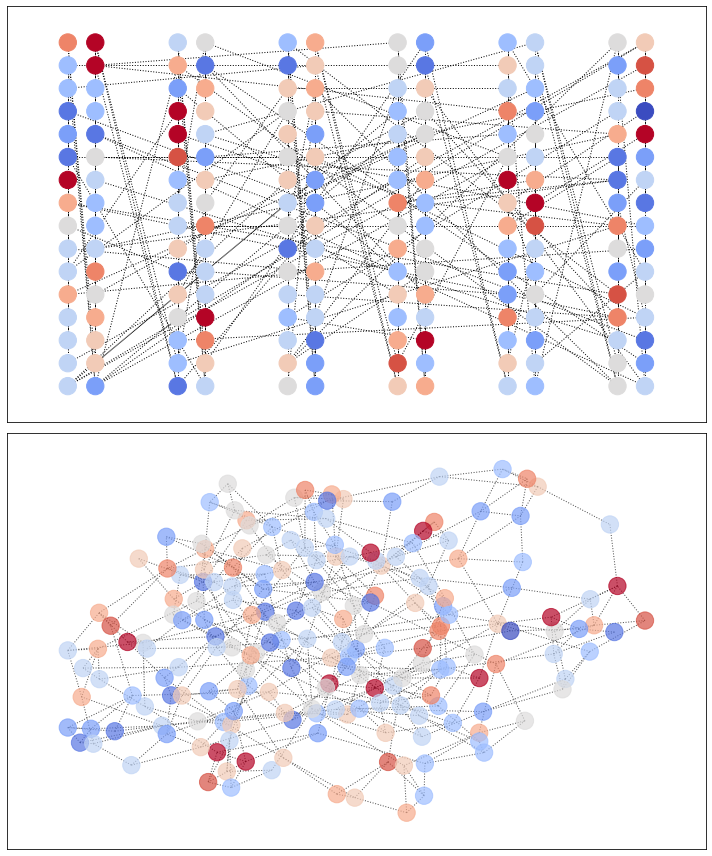

In [4]:
# visualising how ai preferences appear on a knowledge exchange network and based on the physical layout.
fig=plt.figure(figsize=(10,12), tight_layout=True)
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
nx.draw_networkx(G, pos=Pos, 
                node_color=aiPref, 
                with_labels=False, 
                ax=ax0, 
                cmap=('coolwarm'), 
                style=':')
nx.draw_networkx(G, node_color=aiPref, 
                with_labels=False, 
                ax=ax1, 
                cmap=('coolwarm'), 
                style=':', 
                alpha=0.7)
plt.show()
# placement does not seem to show any changes in ai prefrence 
# and even the knowledge echange does not necesarrily imply similarity in preferences. 

In [5]:
node_df = pd.DataFrame({'Nodes':G.nodes, 
                        'AI': aiPref, 
                        'x_pos': [i[1]['x_pos'] for i in node_data], 
                        'y_pos': [i[1]['y_pos'] for i in node_data], 
                        'Degrees':[i[1] for i in G.degree]}).set_index(['Nodes'])

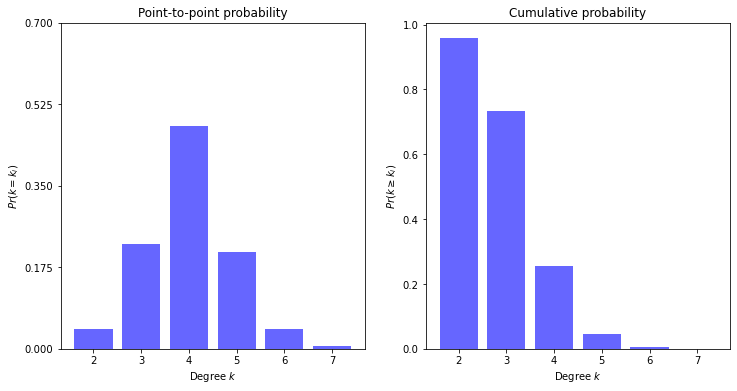


    Summary stats on degree distribution

Mu    :       4.000

Min   :           2
Max   :           7


Sigma :       0.901


Number of Edges in the network: 384
Number of Nodes in the network: 192
Density of the network: 0.020942408376963352
Diameter of the network: 9
Average clustering in the network: 0.24935515873015882


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

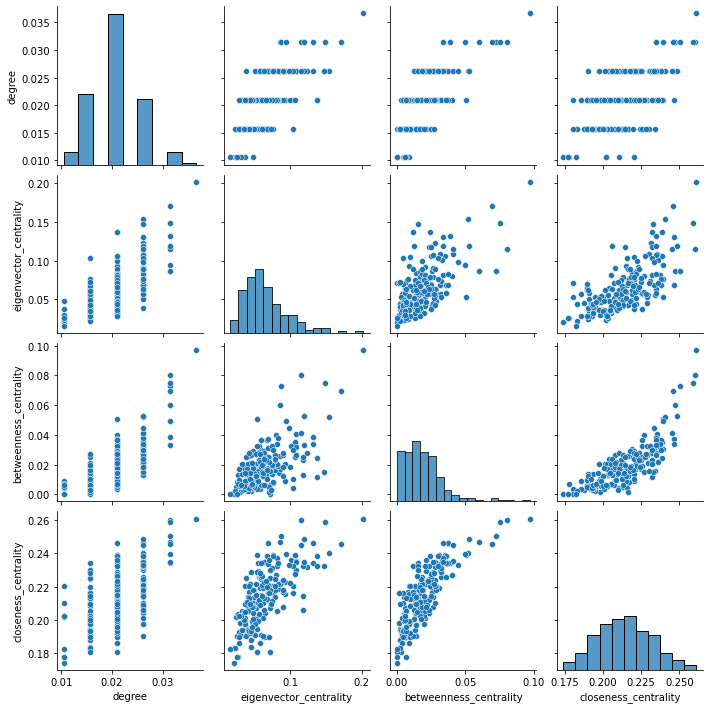

In [6]:
k_rn = sorted([d for n, d in G.degree], reverse=True)
# get 'p_k'
# --+ point-to-point probability
p_k = np.unique(k_rn, return_counts=True)
# --+ cumulative probability
cp_k = np.unique(k_rn, return_index=True)

df_subset_degree = pd.DataFrame(k_rn)
# create figure
fig = plt.figure(figsize=(12, 6))

# add plot
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# point-to-point data
# --+ plot data
ax0.bar(p_k[0], p_k[1]/len(G.degree), color='blue', alpha=0.6)
yticks = np.linspace(0,0.7, 5)
ax0.set_yticks(yticks)
# --+ title
ax0.set_title("Point-to-point probability")
# --+ labels
ax0.set_ylabel("$Pr(k = k_{i})$")
ax0.set_xlabel("Degree $k$")

# cumulative probability
# --+ plot data
ax1.bar(cp_k[0], cp_k[1]/len(G.degree), color='blue', alpha=0.6)
# --+ title
ax1.set_title("Cumulative probability")
# --+ labels
ax1.set_ylabel("$Pr(k \geq k_{i})$")
ax1.set_xlabel("Degree $k$")

# show plot
plt.show()

#Saving the graphs

plt.savefig('Degree Distribution.png')
print("""
==============================================
    Summary stats on degree distribution
==============================================

Mu    :       {:.3f}

Min   :       {:>5}
Max   :       {:>5}


Sigma :       {:.3f}

""" 
.format(np.mean(k_rn), np.min(k_rn), np.max(k_rn), np.std(k_rn)))
# Decriptive Statistics
No_of_edges = nx.number_of_edges(G)
No_of_nodes = nx.number_of_nodes(G)
Density = nx.density(G)
Diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)]) #since the network is weakly connected, we cannot use the nx.diameter(G) function directly
Avg_clustering = nx.average_clustering(G)
Avg_degree_connectivity = nx.average_degree_connectivity(G)
#Avg_path_length = nx.average_shortest_path_length(G)
print ("Number of Edges in the network:", No_of_edges)
print ("Number of Nodes in the network:", No_of_nodes)
print ("Density of the network:", Density)
print ("Diameter of the network:", Diameter)
print ("Average clustering in the network:", Avg_clustering)
# Centrality Measures
# degree centrality
dc = nx.degree_centrality(G)

# eigenvector_centrality
ec = nx.eigenvector_centrality(G)

# betweeness centrality
bc = nx.betweenness_centrality(G)

# closeness centrality
close_centrality = nx.closeness_centrality(G)
df = pd.DataFrame({'degree': dc, 'eigenvector_centrality': ec,
                   'betweenness_centrality': bc, 'closeness_centrality': close_centrality})
# --+ correlation matrix
df.corr()
# --+ scatter plot matrix
plt.figure()
sns.pairplot(df)

plt.savefig('corr.png')

In [7]:
# find nodes with highest betweenness, closeness, and eigen
bc_vals = [i for i in bc.values()]
ec_vals = [i for i in ec.values()]
dc_vals = [i for i in dc.values()]
cc_vals = [i for i in close_centrality.values()]

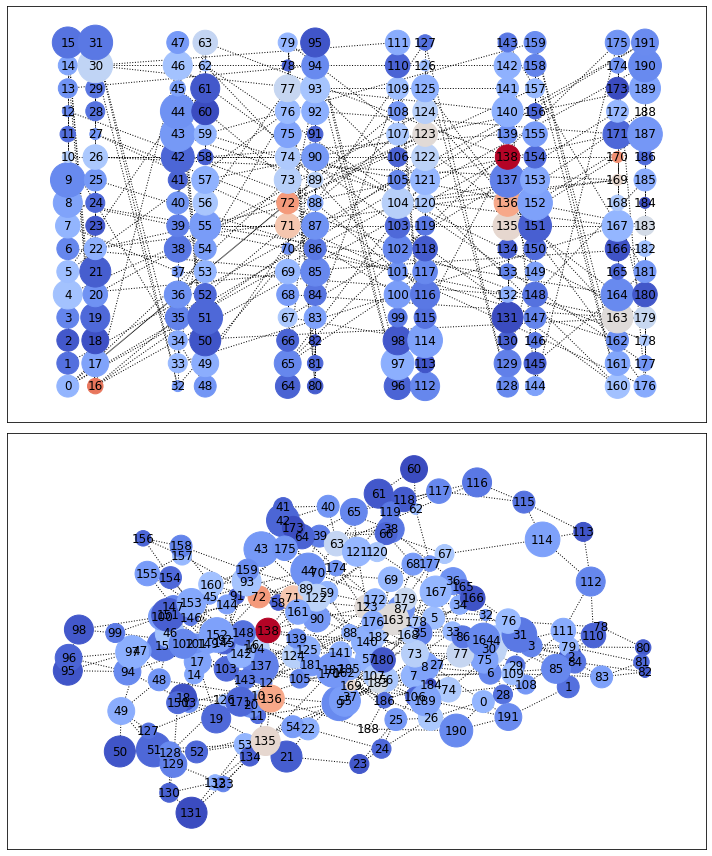

In [8]:
fig=plt.figure(figsize=(10,12), tight_layout=True)
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
nx.draw_networkx(G, pos=Pos, 
                node_color=bc_vals,
                node_size = node_df['AI']*120, 
                with_labels=True, 
                ax=ax0, 
                cmap=('coolwarm'), 
                style=':')
nx.draw_networkx(G,
                node_color=bc_vals,
                node_size = node_df['AI']*120, 
                with_labels=True, 
                ax=ax1, 
                cmap=('coolwarm'), 
                style=':')

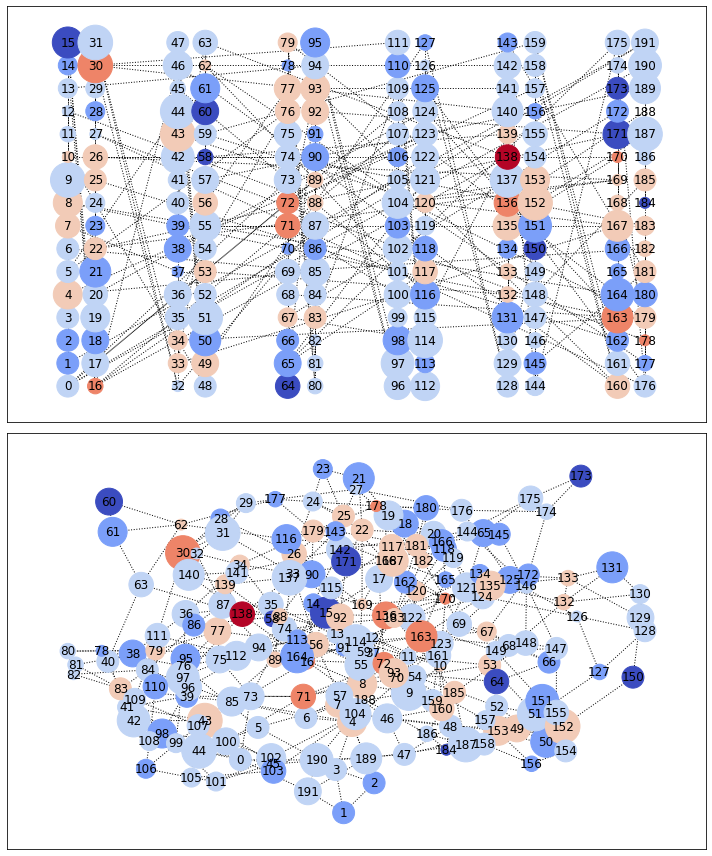

In [9]:
fig=plt.figure(figsize=(10,12), tight_layout=True)
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
nx.draw_networkx(G, pos=Pos, 
                node_color=dc_vals,
                node_size = node_df['AI']*120, 
                with_labels=True, 
                ax=ax0, 
                cmap=('coolwarm'), 
                style=':')
nx.draw_networkx(G,
                node_color=dc_vals,
                node_size = node_df['AI']*120, 
                with_labels=True, 
                ax=ax1, 
                cmap=('coolwarm'), 
                style=':')

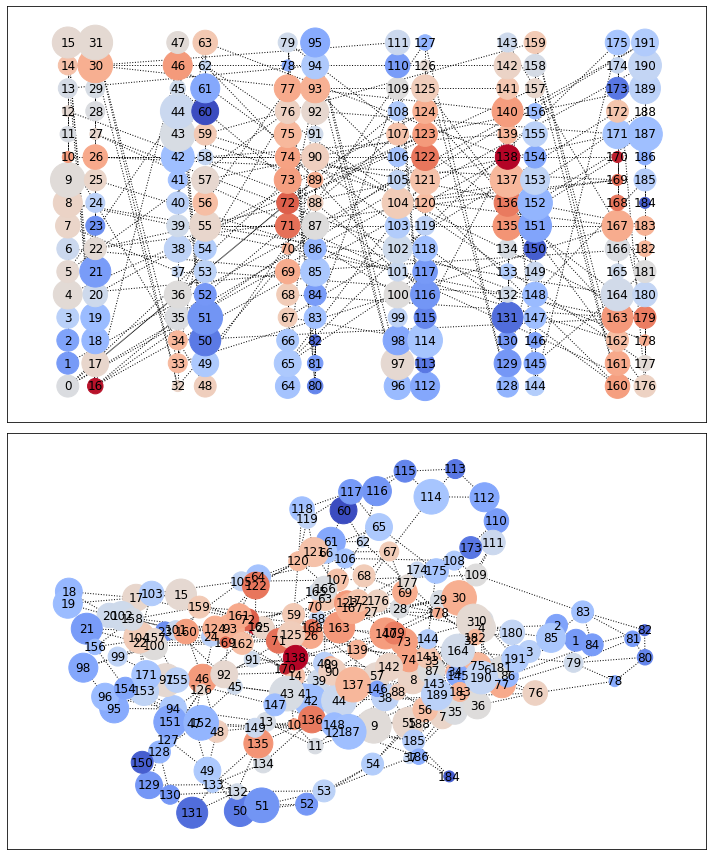

In [10]:
fig=plt.figure(figsize=(10,12), tight_layout=True)
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
nx.draw_networkx(G, pos=Pos, 
                node_color=cc_vals,
                node_size = node_df['AI']*120, 
                with_labels=True, 
                ax=ax0, 
                cmap=('coolwarm'), 
                style=':')
nx.draw_networkx(G,
                node_color=cc_vals,
                node_size = node_df['AI']*120, 
                with_labels=True, 
                ax=ax1, 
                cmap=('coolwarm'), 
                style=':')

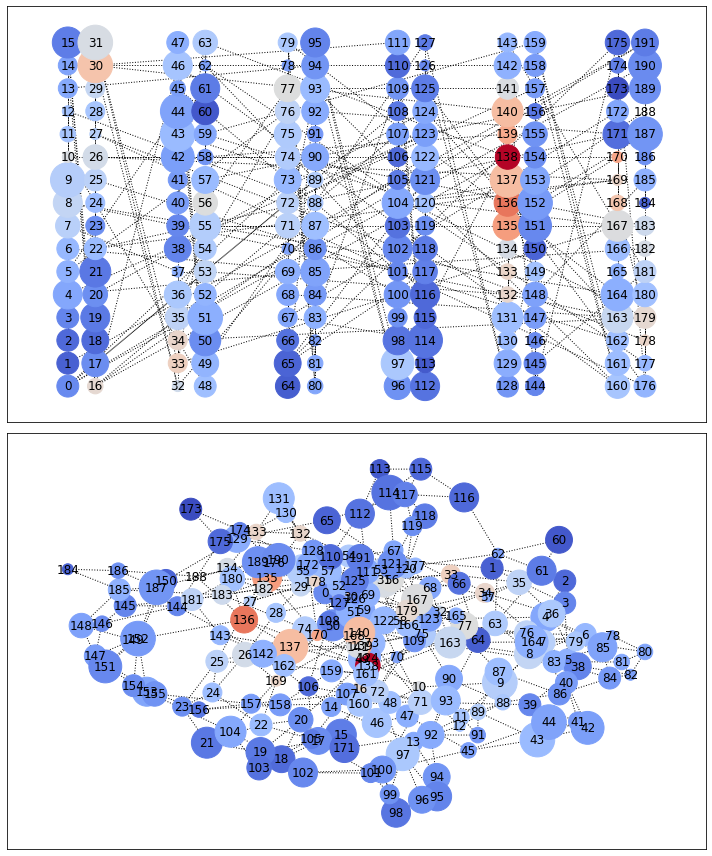

In [11]:
fig=plt.figure(figsize=(10,12), tight_layout=True)
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
nx.draw_networkx(G, pos=Pos, 
                node_color=ec_vals,
                node_size = node_df['AI']*120, 
                with_labels=True, 
                ax=ax0, 
                cmap=('coolwarm'), 
                style=':')
nx.draw_networkx(G,
                node_color=ec_vals,
                node_size = node_df['AI']*120, 
                with_labels=True, 
                ax=ax1, 
                cmap=('coolwarm'), 
                style=':')

In [12]:
node_df['EC'] = ec_vals
node_df['BC'] = bc_vals
node_df['DC'] = dc_vals
node_df['CC'] = cc_vals

In [13]:
node_df.sort_values('EC', ascending=False) #nodes 138, 136, 135, 170, 139

AI  x_pos  y_pos  Degrees        EC        BC        DC        CC
Nodes                                                                   
138     5     17     10        7  0.202053  0.096939  0.036649  0.260929
136     6     17      8        6  0.170673  0.069239  0.031414  0.245501
135     7     17      7        5  0.153790  0.052009  0.026178  0.240252
170     1     21     10        6  0.149143  0.075024  0.031414  0.258808
139     3     17     11        5  0.147157  0.015233  0.026178  0.232643
...    ..    ...    ...      ...       ...       ...       ...       ...
1       4      1      1        3  0.024720  0.008319  0.015707  0.190429
64      5      9      0        2  0.023576  0.004986  0.010471  0.201690
113     3     14      1        3  0.021781  0.002239  0.015707  0.182775
60      6      6     12        2  0.021269  0.000000  0.010471  0.174111
173     4     21     13        2  0.015691  0.000000  0.010471  0.182600

[192 rows x 8 columns]

In [14]:
node_df.sort_values('BC', ascending=False) #nodes 138, 16, 170, 72, 136

AI  x_pos  y_pos  Degrees        EC        BC        DC        CC
Nodes                                                                   
138     5     17     10        7  0.202053  0.096939  0.036649  0.260929
16      2      2      0        6  0.114733  0.080555  0.031414  0.259864
170     1     21     10        6  0.149143  0.075024  0.031414  0.258808
72      4      9      8        6  0.087021  0.072564  0.031414  0.250328
136     6     17      8        6  0.170673  0.069239  0.031414  0.245501
...    ..    ...    ...      ...       ...       ...       ...       ...
18      6      2      2        3  0.029233  0.001402  0.015707  0.197927
131     8     17      3        3  0.071347  0.000032  0.015707  0.180700
60      6      6     12        2  0.021269  0.000000  0.010471  0.174111
184     1     22      8        2  0.025655  0.000000  0.010471  0.177344
173     4     21     13        2  0.015691  0.000000  0.010471  0.182600

[192 rows x 8 columns]

In [15]:
node_df.sort_values('DC', ascending=False) #nodes 138, 178, 30, 72, 71

AI  x_pos  y_pos  Degrees        EC        BC        DC        CC
Nodes                                                                   
138     5     17     10        7  0.202053  0.096939  0.036649  0.260929
178     1     22      2        6  0.118792  0.033491  0.031414  0.234644
30     10      2     14        6  0.132282  0.038741  0.031414  0.234356
72      4      9      8        6  0.087021  0.072564  0.031414  0.250328
71      5      9      7        6  0.086106  0.059935  0.031414  0.247089
...    ..    ...    ...      ...       ...       ...       ...       ...
171     7     21     11        2  0.030310  0.006242  0.010471  0.202116
150     4     18      6        2  0.026231  0.006886  0.010471  0.177674
58      2      6     10        2  0.048016  0.004434  0.010471  0.210352
15      8      1     15        2  0.037077  0.008786  0.010471  0.220300
60      6      6     12        2  0.021269  0.000000  0.010471  0.174111

[192 rows x 8 columns]

In [16]:
node_df.sort_values('CC', ascending=False) #nodes 138, 16, 170, 72, 169

AI  x_pos  y_pos  Degrees        EC        BC        DC        CC
Nodes                                                                   
138     5     17     10        7  0.202053  0.096939  0.036649  0.260929
16      2      2      0        6  0.114733  0.080555  0.031414  0.259864
170     1     21     10        6  0.149143  0.075024  0.031414  0.258808
72      4      9      8        6  0.087021  0.072564  0.031414  0.250328
169     1     21      9        5  0.119133  0.052575  0.026178  0.248698
...    ..    ...    ...      ...       ...       ...       ...       ...
131     8     17      3        3  0.071347  0.000032  0.015707  0.180700
82      1     10      2        4  0.053405  0.003354  0.020942  0.180359
150     4     18      6        2  0.026231  0.006886  0.010471  0.177674
184     1     22      8        2  0.025655  0.000000  0.010471  0.177344
60      6      6     12        2  0.021269  0.000000  0.010471  0.174111

[192 rows x 8 columns]

In [17]:
node_df.iloc[list(G.neighbors('138'))]
node_df.iloc[list(G.neighbors('72'))]
node_df.iloc[list(G.neighbors('136'))]

AI  x_pos  y_pos  Degrees        EC        BC        DC        CC
Nodes                                                                   
134     3     17      6        3  0.103339  0.004441  0.015707  0.215819
135     7     17      7        5  0.153790  0.052009  0.026178  0.240252
137    10     17      9        4  0.137058  0.011809  0.020942  0.232360
138     5     17     10        7  0.202053  0.096939  0.036649  0.260929
149     3     18      5        4  0.074438  0.019696  0.020942  0.211517
188     0     22     12        3  0.060757  0.019929  0.015707  0.214126

In [18]:
#Girvman-Newman - community detection

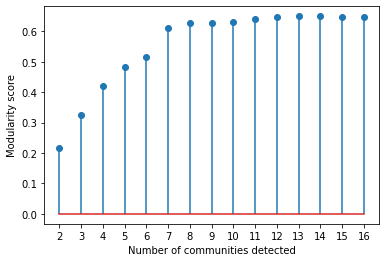

In [19]:
#    paritioning solutions
# fit
solutions = girvan_newman(G)
# alternative paritioning solutions to consider
k = 15
# register modularity scores
modularity_scores = dict()
# iterate over solutions
for community in itertools.islice(solutions, k):
    solution = list(sorted(c) for c in community)
    score = modularity(G, solution)
    modularity_scores[len(solution)] = score
# plot modularity data
fig = plt.figure()
pos = list(modularity_scores.keys())
values = list(modularity_scores.values())
ax = fig.add_subplot(1, 1, 1)
ax.stem(pos, values)
ax.set_xticks(pos)
ax.set_xlabel(r'Number of communities detected')
ax.set_ylabel(r'Modularity score')
plt.show()
# the plot shows equally maximised modularity score at 13 and 14 communities. For better interpretability, 13 communities were chosen.

In [20]:
# retrieve the first 'k' community-solution
# --+ fit
solutions = girvan_newman(G)
# --+ display node2community affiliations
k = 12
for community in itertools.islice(solutions, k):
    communities = (list(sorted(c) for c in community))

In [21]:
node_community=[]
for i in communities:
    for j in i:
        node_community.append(int(communities.index(i)))

nodes_community_order = []
for i in communities:
    for j in i:
        nodes_community_order.append(int(j))

In [22]:
community_df = pd.DataFrame({'Node': nodes_community_order, 'node_community': node_community}).sort_values('Node') #.set_index('Node',drop=True)

In [23]:
node_df['Community'] = np.array(community_df['node_community'])

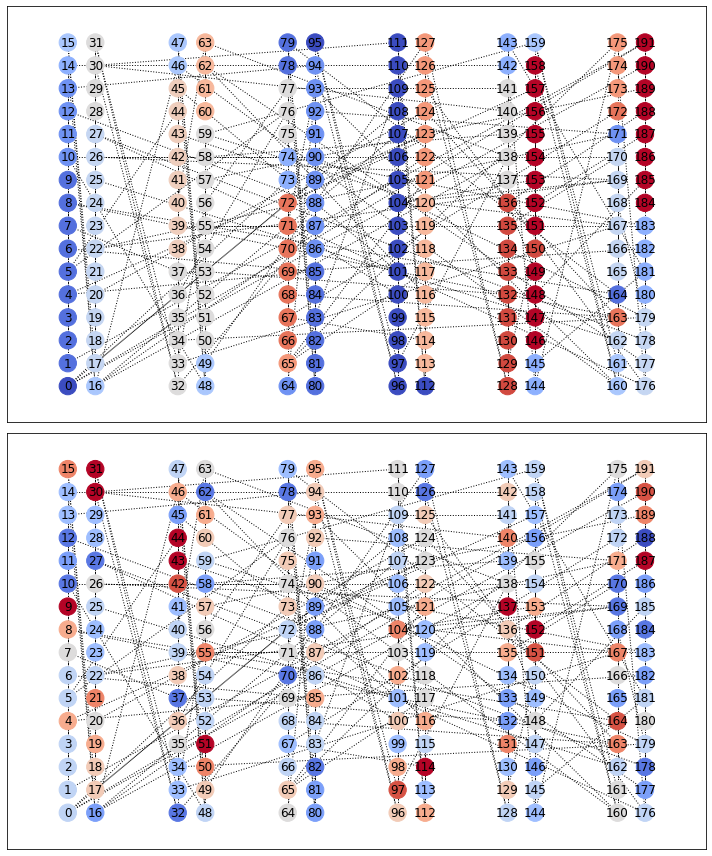

In [24]:
fig=plt.figure(figsize=(10,12), tight_layout=True)
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
nx.draw_networkx(G, pos=Pos, 
                node_color=node_df['Community'], 
                with_labels=True, 
                ax=ax0, 
                cmap=('coolwarm'), 
                style=':')
nx.draw_networkx(G, pos=Pos,
                node_color=aiPref, 
                with_labels=True, 
                ax=ax1, 
                cmap=('coolwarm'), 
                style=':'
                )

In [25]:
comms_groups = [i for i in range(0,13)]
for i in range(len(comms_groups)):
    comms_groups[i]= node_df.set_index(['Community']).loc[i]

In [26]:
for i in range(len(comms_groups)):
    print(str(i)+':', np.mean(comms_groups[i]['AI']))

0: 5.2105263157894735
1: 4.555555555555555
2: 4.0
3: 4.0
4: 5.0
5: 3.909090909090909
6: 5.25
7: 6.0
8: 4.916666666666667
9: 4.454545454545454
10: 4.222222222222222
11: 4.5
12: 4.9


In [27]:
node_df.groupby(['Community']).mean()

AI      x_pos      y_pos   Degrees        EC        BC  \
Community                                                                 
0          5.210526  12.263158   7.105263  3.736842  0.043773  0.015958   
1          4.555556   6.000000   5.166667  4.055556  0.059828  0.014420   
2          4.000000   8.266667   9.800000  3.866667  0.062266  0.017541   
3          4.000000  16.090909   7.727273  3.909091  0.070896  0.022360   
4          5.000000   9.444444   6.777778  4.222222  0.070361  0.027334   
5          3.909091  11.681818   5.409091  4.181818  0.078673  0.021642   
6          5.250000   7.500000   8.035714  4.250000  0.096255  0.021822   
7          6.000000   5.000000   9.500000  3.875000  0.051839  0.013051   
8          4.916667  11.333333   7.500000  3.750000  0.041521  0.014340   
9          4.454545  15.454545  11.545455  3.545455  0.040843  0.023569   
10         4.222222  11.666667   5.555556  4.444444  0.065555  0.034288   
11         4.500000  17.100000   4.200000  4.100000  0.094161  0.020173   
12         4.900000  19.600000   9.500000  3.900000  0.048757  0.014318   

                 DC        CC  
Community                      
0          0.019565  0.208696  
1          0.021233  0.204424  
2          0.020244  0.217710  
3          0.020466  0.221077  
4          0.022106  0.229732  
5          0.021894  0.222133  
6          0.022251  0.220912  
7          0.020288  0.208825  
8          0.019634  0.199731  
9          0.018563  0.217318  
10         0.023269  0.232101  
11         0.021466  0.205649  
12         0.020419  0.202729

In [28]:
for i in range(len(comms_groups)):
    print(str(i)+':', 
    (len(node_df[(node_df['Community']==i) & (node_df['AI']>5)])/
    (len(node_df[node_df['Community']==i]))*100))

0: 42.10526315789473
1: 27.77777777777778
2: 40.0
3: 18.181818181818183
4: 33.33333333333333
5: 22.727272727272727
6: 39.285714285714285
7: 50.0
8: 33.33333333333333
9: 36.36363636363637
10: 11.11111111111111
11: 40.0
12: 35.0


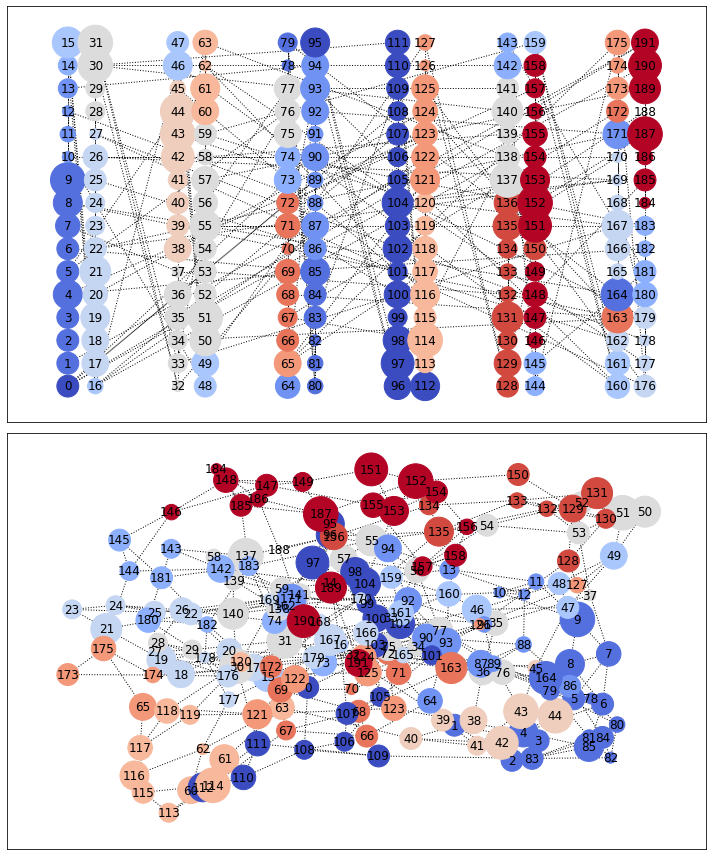

In [29]:
fig=plt.figure(figsize=(10,12), tight_layout=True)
ax0 = fig.add_subplot(211)
ax1 = fig.add_subplot(212)
nx.draw_networkx(G, pos=Pos, ax=ax0,
                node_color=node_df['Community'], 
                with_labels=True, 
                node_size = node_df['AI']*120,
                cmap=('coolwarm'), 
                style=':',
                )
nx.draw_networkx(G, ax=ax1,
                node_color=node_df['Community'], 
                with_labels=True, 
                node_size = node_df['AI']*120,
                cmap=('coolwarm'), 
                style=':',
                )

In [30]:
node_df.groupby(['AI']).count()

x_pos  y_pos  Degrees  EC  BC  DC  CC  Community
AI                                                  
0       1      1        1   1   1   1   1          1
1      14     14       14  14  14  14  14         14
2      20     20       20  20  20  20  20         20
3      27     27       27  27  27  27  27         27
4      40     40       40  40  40  40  40         40
5      26     26       26  26  26  26  26         26
6      23     23       23  23  23  23  23         23
7      16     16       16  16  16  16  16         16
8      10     10       10  10  10  10  10         10
9       5      5        5   5   5   5   5          5
10     10     10       10  10  10  10  10         10

In [31]:
len(node_df[node_df['AI']>5])/len(node_df)                

0.3333333333333333

In [32]:
coords_dist = scipy.spatial.distance_matrix(node_df.iloc[:,1:3], node_df.iloc[:,1:3])
node_dist = coords_dist[np.tril_indices(192,k=-1)]

In [33]:
diffs = np.abs(np.array(aiPref) - np.array(aiPref)[:,None])
AI_diffs = diffs[np.tril_indices(192,k=-1)]

/Users/agamchug/.conda/envs/pythonProject1/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

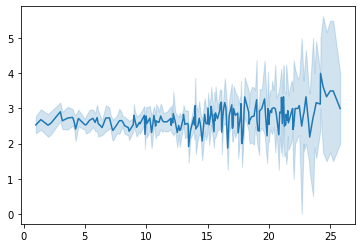

In [34]:
sns.lineplot(node_dist,AI_diffs)

In [35]:
import statsmodels.api as sm
Y = AI_diffs
X = node_dist
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()               

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     17.11
Date:                Fri, 17 Dec 2021   Prob (F-statistic):           3.55e-05
Time:                        14:43:45   Log-Likelihood:                -39001.
No. Observations:               18336   AIC:                         7.801e+04
Df Residuals:                   18334   BIC:                         7.802e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5252      0.034     74.333      0.000       2.459       2.592
x1             0.0120      0.003      4.136      0.000       0.006       0.018
==============================================================================
Omnibus:                     1614.266   Durbin-Watson:                   1.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2075.682
Skew:                           0.819   Prob(JB):                         0.00
Kurtosis:                       3.187   Cond. No.                         26.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# initialize the diffusione process
# parameters
# get degree 'd'
def diffusion(t): # t = threshold above which to label early adopters
    degree = nx.degree(G)
    # initial state
    # --+ the list of adopters is empty
    adopters = []
    # --+ everybody sticks with the status quo
    #     let's create a node-level attribute reflecting adoption
    for node in G.nodes:
        G.nodes[node]["adopting"] = 0
    # ----+ double-check attributes
# model the diffusion process
# at time 1 there are early adopters emerge for some reasons
# --+ new adopters

    early_adopters = [i for i in node_df[node_df['AI']>t].index]
    # --+ expand the set of adopters
    adopters.extend(early_adopters)

    # --+ adopt node attributes
    for adopter in adopters:
        G.nodes[adopter]['adopting'] = 1
#draw the network
    colors_pre = []
    for n in G.nodes:
        if G.nodes[n]['adopting'] == 1:
            colors_pre.append('orange')
        else:
            colors_pre.append('grey')
    initial_adopters = 0
    for color in colors_pre:
        if color == 'orange':
            initial_adopters += 1
#let's simulate what happens in the following periods as nodes make decisions
    for focal in node_df.index:
        # count adopting neighbors
        focal_nbrs = list(G.neighbors(focal))
        p = np.sum([G.nodes[nbr]['adopting'] for nbr in focal_nbrs])
        nbr_adopting = [nbr for nbr in focal_nbrs if G.nodes[nbr]['adopting']==1]
        nbr_not_adopting = [nbr for nbr in focal_nbrs if G.nodes[nbr]['adopting']==0]
    # pay-off of adopting new behavior=, taken as weighted average of neighbours' AI opinions
        for nbr in focal_nbrs:
            a = (node_df.loc[nbr_adopting]['AI']).mean() * node_df.loc[focal]['AI']
            b = (node_df.loc[nbr_not_adopting]['AI']).mean() * node_df.loc[focal]['AI']
        d = G.degree(focal)
        a_payoff = p * a
        b_payoff = (d - p ) * b
        # decision to adopt
        if (G.nodes[focal]['adopting'] == 0) & (a_payoff > b_payoff):
            G.nodes[focal]['adopting'] = 1
            adopters.extend(focal)
        else:
            pass
# outcome of the cascading behavior
    adopters

# draw the network
    colors_post = []
    for n in G.nodes():
        if G.nodes[n]['adopting'] == 1:
            colors_post.append('orange')
        else:
            colors_post.append('grey')        
    final_adopters = 0
    for color in colors_post:
        if color == 'orange':
            final_adopters += 1

    
    

    fig = plt.figure(figsize=(10,12),tight_layout=True)
    ax0 = fig.add_subplot(211)
    ax1 = fig.add_subplot(212)
    print('Before Diffusion:', initial_adopters/192)
    nx.draw_networkx(G, pos=Pos, with_labels=True, node_color=colors_pre,ax=ax0, node_size=(node_df['Community']+1)*(100),label='Before')
    nx.draw_networkx(G, pos=Pos, with_labels=True, node_color=colors_post,ax=ax1, node_size=(node_df['Community']+1)*(100),label='After')
    print('After Diffusion:', final_adopters/192)

# %

Before Diffusion: 0.21354166666666666
After Diffusion: 0.5


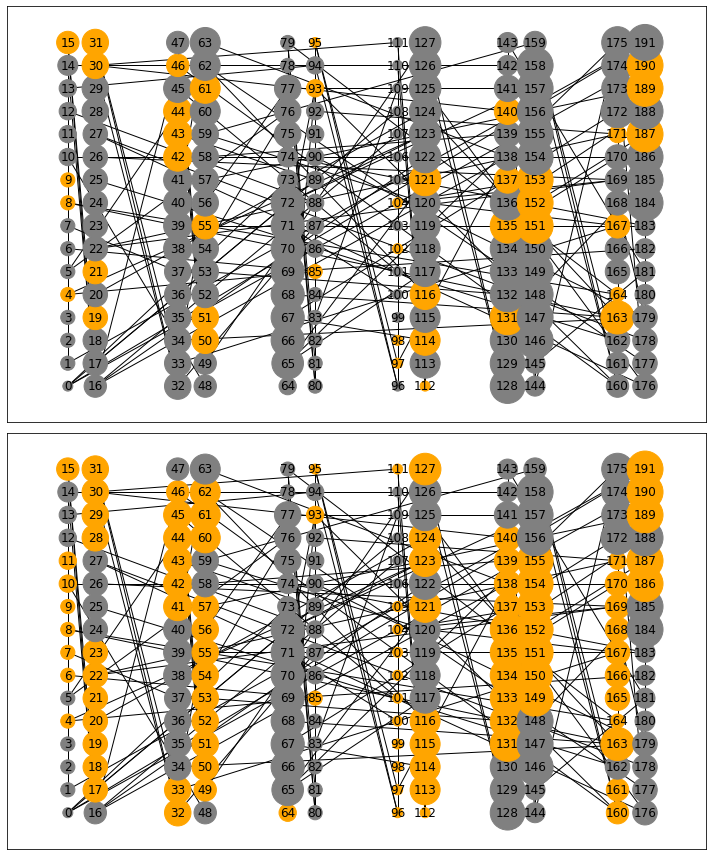

In [45]:
diffusion(6)

In [ ]:
! brew install --cask mactex

Error: Cannot install under Rosetta 2 in ARM default prefix (/opt/homebrew)!
To rerun under ARM use:
    arch -arm64 brew install ...
To install under x86_64, install Homebrew into /usr/local.
Error: 'git' must be installed and in your PATH!
==> Caveats
You must restart your terminal window for the installation of MacTex CLI tools to take effect.
Alternatively, Bash and Zsh users can run the command:

  eval "$(/usr/libexec/path_helper)"

==> Downloading http://mirror.ctan.org/systems/mac/mactex/mactex-20210328.pkg
==> Downloading from https://ctan.asis.ai/systems/mac/mactex/mactex-20210328.pkg
                                                                           0.1%